# Beyin Tümör Detection

Bu çalışmada, beyin tümörlerini sınıflandırmak için bir Convolutional Neural Network (CNN) modeli geliştirilmiştir. Eğitim ve test verileri, MRI görüntülerinden oluşan Brain Tumor Classification Dataset kullanılarak hazırlanmıştır. Model, dört farklı sınıfı ayırt etmeyi amaçlamaktadır: glioma, meningioma, notumor ve pituitary. Görüntüler, veri artırma (augmentation) ve normalizasyon teknikleri uygulanarak modele beslenmiş, modelin performansı accuracy, loss, confusion matrix ve classification report ile değerlendirilmiştir.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

import keras_tuner as kt

from tensorflow.keras.models import load_model
#import warnings
#warnings.filterwarnings('ignore')

2025-09-25 11:54:24.461167: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758801264.690997      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758801264.764905      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Kütüphaneler**
- `os`: Dosya ve klasör işlemleri için.
- `numpy (np)`: Sayısal hesaplamalar ve matris işlemleri için.
- `matplotlib.pyplot (plt)`: Grafik ve görselleştirme için.
- `ImageDataGenerator` (from `tensorflow.keras.preprocessing.image`): Görüntüleri model için hazırlama ve artırma (augmentation) işlemleri.
- `tensorflow (tf)`: Derin öğrenme modelleri oluşturmak için temel kütüphane.
- `Sequential` (from `tensorflow.keras.models`): Modelleri katman katman (Sequential) oluşturmak için.
- `Conv2D, MaxPooling2D, Flatten, Dense, Dropout` (from `tensorflow.keras.layers`):  
  - `Conv2D`: Convolution katmanı  
  - `MaxPooling2D`: Havuzlama katmanı  
  - `Flatten`: Çok boyutlu tensörü tek boyuta çevirme  
  - `Dense`: Tam bağlı katman  
  - `Dropout`: Overfitting önleme
- `load_model` (from `tensorflow.keras.models`): Daha önce kaydedilmiş modeli yüklemek için.

In [2]:
#Parametreler
img_size = (150, 150)
batch_size = 32
train_path = "/kaggle/input/brain-tumor-mri-dataset/Training"
test_path  = "/kaggle/input/brain-tumor-mri-dataset/Testing"

# **Parametreler**
- `img_size = (150, 150)`: Modelin girişine verilecek görüntülerin boyutu (150x150 piksel).  
- `batch_size = 32`: Modelin her eğitim adımında işleyeceği görüntü sayısı.  
- `train_path`: Eğitim verilerinin bulunduğu klasör yolu.  
- `test_path`: Test verilerinin bulunduğu klasör yolu.

In [3]:
#Train + Validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,      # %20 validation
    rotation_range=20,         # augmentation
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

#Test (augmentation yok, sadece normalize)
test_datagen = ImageDataGenerator(rescale=1./255)

#Train Generator
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training"
)

#Validation Generator
val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation"
)

#Test Generator
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


# Veri Ön İşleme ve Generatorlar

## Eğitim ve Validation için
- `ImageDataGenerator` ile görüntüler normalizasyon (`rescale=1./255`) ve veri artırma (augmentation) uygulanıyor:
  - `validation_split=0.2`: Verinin %20’si doğrulama (validation) için ayrılıyor.
  - `rotation_range=20`: Görüntüleri ±20 derece döndürme.
  - `width_shift_range=0.1`, `height_shift_range=0.1`: Görüntüyü yatay/dikey kaydırma.
  - `zoom_range=0.1`: Görüntüyü %10 oranında yakınlaştırma/uzaklaştırma.
  - `horizontal_flip=True`: Yatay çevirme.

## Test için
- `ImageDataGenerator(rescale=1./255)`: Sadece normalize ediliyor, augmentation uygulanmıyor.

## Generatorlar
- `train_generator`: Eğitim verilerini üretir (`subset="training"`).  
- `val_generator`: Validation verilerini üretir (`subset="validation"`).  
- `test_generator`: Test verilerini üretir (`shuffle=False` ile sıralı).  
- `target_size=img_size`: Görüntü boyutu 150x150.  
- `batch_size=batch_size`: Her adımda işlenen görüntü sayısı 32.  
- `class_mode="categorical"`: Çok sınıflı sınıflandırma.

Öncelikle ImageDataGenerator sınıfı ile hem eğitim hem de test verileri için veri ön işleme ve artırma (augmentation) ayarlanıyor. Eğitim verileri için resimler normalize ediliyor (piksel değerleri 0-1 aralığına getiriliyor) ve modelin daha genel ve dayanıklı öğrenmesini sağlamak amacıyla döndürme, kaydırma, yakınlaştırma ve yatay çevirme gibi rastgele değişiklikler uygulanıyor. Ayrıca eğitim verilerinin %20’si doğrulama (validation) için ayrılıyor, böylece modelin eğitim sırasında aşırı öğrenme (overfitting) yapıp yapmadığını takip edebiliyoruz. Ardından flow_from_directory fonksiyonu ile belirtilen klasörlerden eğitim, doğrulama ve test verileri okunuyor, her bir veri grubu uygun boyuta getiriliyor ve modelin kullanabileceği batchler halinde hazırlanıyor. Eğitim ve doğrulama verileri artırma uygulanarak modele farklı örnekler sunarken, test verileri sadece normalize edilerek gerçek performans değerlendirmesi için kullanılıyor. Böylece model hem çeşitlendirilmiş verilerle öğreniyor hem de doğrulama ve test aşamalarında güvenilir sonuçlar elde edebiliyoruz.

In [4]:
print("Sınıflar:", train_generator.class_indices)

Sınıflar: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


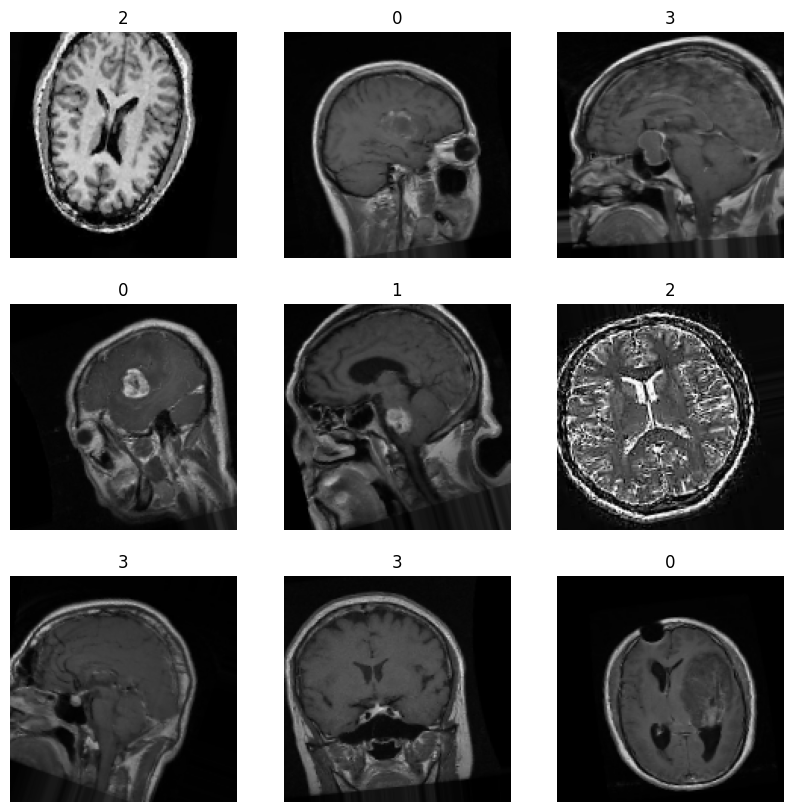

In [5]:
#Sınıf örnek çıktısı
x, y = next(train_generator)

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x[i])
    plt.title(np.argmax(y[i]))
    plt.axis("off")
plt.show()


# Eğitim Verisinden Örnek Görüntüler

- `x, y = next(train_generator)`: Eğitim verisinden bir batch (küme) görüntü ve etiket alır.
- `plt.figure(figsize=(10,10))`: Görsellerin boyutunu ayarlar.
- Döngü ile ilk 9 görüntü görselleştirilir:
  - `plt.imshow(x[i])`: Görüntüyü gösterir.
  - `plt.title(np.argmax(y[i]))`: Görüntünün sınıf etiketini başlık olarak ekler.
  - `plt.axis("off")`: Eksenleri gizler.
- `plt.show()`: Görselleri ekranda gösterir.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-09-25 11:54:45.170818: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,868 (18.42 MB)

 Trainable params: 4,828,868 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 144s 985ms/step - accuracy: 0.5109 - loss: 1.0630 - val_accuracy: 0.6968 - val_loss: 0.8990
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 138s 957ms/step - accuracy: 0.7311 - loss: 0.6597 - val_accuracy: 0.7213 - val_loss: 0.7611
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 144s 969ms/step - accuracy: 0.7821 - loss: 0.5598 - val_accuracy: 0.7362 - val_loss: 0.7560
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 138s 962ms/step - accuracy: 0.8132 - loss: 0.4912 - val_accuracy: 0.7090 - val_loss: 0.7792
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 140s 977ms/step - accuracy: 0.8288 - loss: 0.4722 - val_accuracy: 0.7774 - val_loss: 0.6332
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 134s 937ms/step - accuracy: 0.8352 - loss: 0.4411 - val_accuracy: 0.7520 - val_loss: 0.6222
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 135s 940ms/step - accuracy: 0.8551 - loss: 0.3996 - val_accuracy: 0.7660 - val_loss: 0.6791
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 135s 944ms/step - accuracy: 0.8478 -

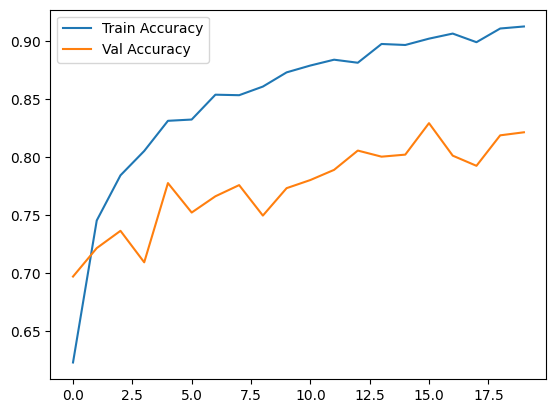

In [6]:
#CNN Modeli
num_classes = 4   # glioma, meningioma, notumor, pituitary

model = Sequential([
    # 1. Convolution + Pooling
    Conv2D(32, (3,3), activation="relu", input_shape=(150,150,3)),
    MaxPooling2D(pool_size=(2,2)),

    # 2. Convolution + Pooling
    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D(pool_size=(2,2)),

    # 3. Convolution + Pooling
    Conv2D(128, (3,3), activation="relu"),
    MaxPooling2D(pool_size=(2,2)),

    # Flatten (2D -> 1D)
    Flatten(),

    # Fully Connected Layers
    Dense(128, activation="relu"),
    Dropout(0.5),   # Overfitting'i engellemek için

    Dense(num_classes, activation="softmax")  # Çok sınıflı sınıflandırma
])

#Model Derlemesi
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

#Model Eğitimi
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20
)

#Model Test
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

# Eğitimi bitirdiğinde kaydet:
model.save("brain_tumor_cnn.h5")

# Sonraki oturumda direkt yükle:
model = load_model("brain_tumor_cnn.h5")

#Grafik Çıktı
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.legend()
plt.show()


# CNN Modeli ve Eğitim Süreci

## Model Yapısı
- `num_classes = 4`: Sınıflar → glioma, meningioma, notumor, pituitary.
- **Convolution + Pooling Katmanları**: İlk üç katmanda Conv2D ile görüntülerdeki özellikleri çıkarıyoruz, yani kenar, şekil veya dokuları öğreniyor. Her konvolüsyon katmanından sonra MaxPooling2D ile boyutu küçülterek modelin daha hızlı ve verimli çalışmasını sağlıyoruz.
  1. `Conv2D(32, (3,3))` + `MaxPooling2D(2,2)`
  2. `Conv2D(64, (3,3))` + `MaxPooling2D(2,2)`
  3. `Conv2D(128, (3,3))` + `MaxPooling2D(2,2)`

- `Flatten()`: 2D veriyi 1D hâline çevirir.
2D feature map’lerini tek boyutlu hale getiriyoruz, böylece tam bağlı (Dense) katmanlara aktarılabiliyor.
  
- **Fully Connected Layers**: Dense katmanlarla öğrenilen özellikleri birleştirip sınıflara tahmin yapacak şekilde model oluşturuluyor. Dropout(0.5) kullanarak overfitting’i azaltıyoruz, yani modelin sadece eğitim verisine fazla uyum sağlamasını engelliyoruz. Ayrıca son katmanda softmax aktivasyonu kullanılarak dört sınıfa olasılık atanıyor.
  - `Dense(128, activation="relu")`
  - `Dropout(0.5)`: Overfitting’i önlemek için.
  - `Dense(num_classes, activation="softmax")`: Çok sınıflı sınıflandırma.

## Model Derlemesi
- `optimizer="adam"`: Öğrenme optimizasyonu.
- `loss="categorical_crossentropy"`: Çok sınıflı sınıflandırma için kayıp fonksiyonu.
- `metrics=["accuracy"]`: Başarı ölçütü doğruluk (accuracy).

## Model Eğitimi
- `history = model.fit(...)`: Modeli eğitim verisi ile istenilen sayı kadar epoch boyunca eğitir.
- `validation_data=val_generator`: Doğrulama verisi ile her epoch sonrası kontrol.

## Test ve Kaydetme
- `test_loss, test_acc = mode


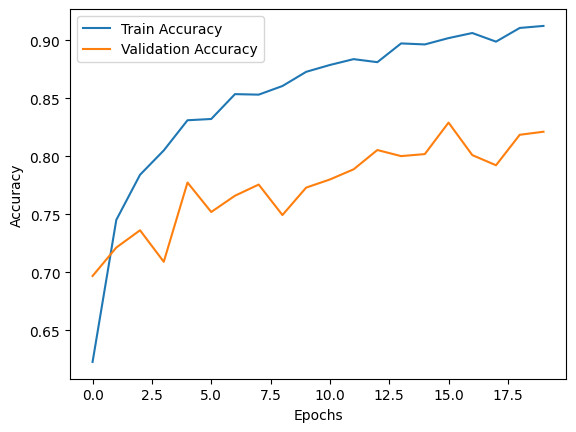

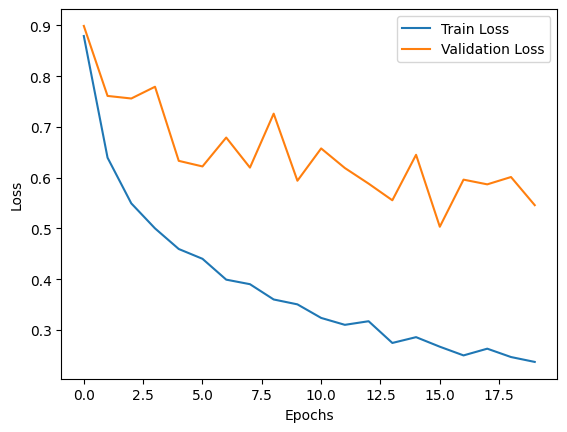

In [7]:
#Accuracy ve Loss Grafikleri
import matplotlib.pyplot as plt

#Accuracy
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#Loss
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


# Eğitim Sonuçlarının Görselleştirilmesi

## Accuracy Grafiği
- `history.history['accuracy']`: Eğitim doğruluğu.
- `history.history['val_accuracy']`: Validation doğruluğu.
- X ekseni: Epoch sayısı, Y ekseni: Accuracy.
- `plt.legend()` ile etiketler gösterilir.

### Eğitim ve Doğrulama Doğruluk (Accuracy)

Grafikte Train Accuracy değerinin epochlar boyunca düzenli bir şekilde arttığı ve yaklaşık 0.90 seviyelerine ulaştığı görülmektedir. Validation Accuracy ise daha dalgalı bir seyir izlemesine rağmen genel olarak yükselmiş ve 0.80 civarında dengelenmiştir. Bu sonuç, modelin eğitim verisini başarılı bir şekilde öğrendiğini ve doğrulama verisinde de kabul edilebilir bir genelleme sağladığını göstermektedir.


## Loss Grafiği
- `history.history['loss']`: Eğitim kaybı.
- `history.history['val_loss']`: Validation kaybı.
- X ekseni: Epoch sayısı, Y ekseni: Loss.
- `plt.legend()` ile etiketler gösterilir.

### Eğitim ve Doğrulama Kaybı (Loss) Grafiği

Grafikte Train Loss değerinin her epoch’ta düzenli olarak azaldığı ve 0.2 seviyelerine kadar gerilediği görülmektedir. Buna karşın Validation Loss dalgalı bir yapı sergilemiş ve Train Loss değerine göre daha yüksek seviyelerde kalmıştır. Bu durum, modelin eğitim setine iyi uyum sağladığını ancak doğrulama setinde kısmi bir overfitting sorunu yaşadığını ortaya koymaktadır. Temel sebepler olarak katman ve filtre sayısının veri setine göre fazla olması ya da augmentasyonun az olması gösterilebilir.

41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 257ms/step


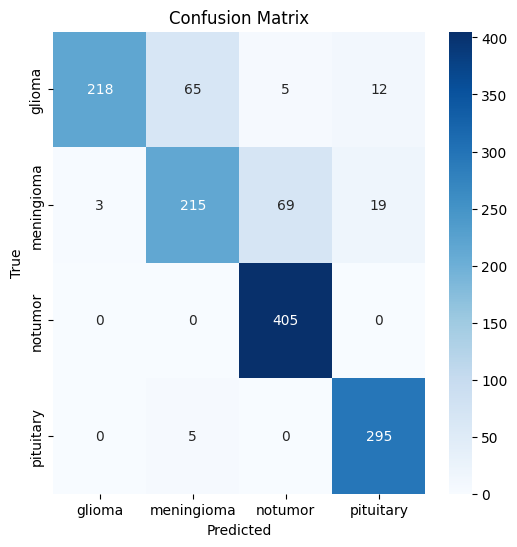

              precision    recall  f1-score   support

      glioma       0.99      0.73      0.84       300
  meningioma       0.75      0.70      0.73       306
     notumor       0.85      1.00      0.92       405
   pituitary       0.90      0.98      0.94       300

    accuracy                           0.86      1311
   macro avg       0.87      0.85      0.86      1311
weighted avg       0.87      0.86      0.86      1311



In [8]:
#Confusion Matrix ve Classification Report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

#Test setinden tahmin al
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

#Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

#Classification Report
print(classification_report(y_true, y_pred_classes, 
                            target_names=test_generator.class_indices.keys()))


# Confusion Matrix ve Classification Report

## Tahminler
- `y_pred = model.predict(test_generator)`: Test verisi ile modelin tahminleri.
- `y_pred_classes = np.argmax(y_pred, axis=1)`: Tahmin edilen sınıflar.
- `y_true = test_generator.classes`: Gerçek sınıflar.

## Confusion Matrix
- `confusion_matrix(y_true, y_pred_classes)`: Modelin hangi sınıfları doğru/yanlış tahmin ettiğini gösterir.
- `sns.heatmap(...)`: Confusion matrix’i görselleştirir.
  - `annot=True`: Değerleri hücrelerde gösterir.
  - `xticklabels` ve `yticklabels`: Sınıf isimleri.
  - `cmap="Blues"`: Renk skalası.

## Classification Report
- `classification_report(y_true, y_pred_classes, target_names=...)`:  
  - Precision, Recall, F1-Score ve Support değerlerini verir.
  - Her sınıf için model performansını özetler.

# Confusion Matrix Yorumları

- `glioma`: Precision değeri 0.99 ile oldukça yüksek olmasına rağmen, recall değeri 0.73’te kalmıştır. Bu durum, modelin glioma örneklerini doğru tanımladığında güvenilir olduğunu, ancak gerçek glioma vakalarının bir kısmını kaçırdığını göstermektedir. Confusion matrix incelendiğinde, glioma sınıfının sıklıkla meningioma ile karıştığı görülmektedir.
- `meningioma`: Precision 0.75, recall 0.70 ve f1-score 0.73 ile en düşük başarıya sahip sınıf olmuştur. Özellikle meningioma örneklerinin bir kısmı notumor (69 örnek) ve pituitary (19 örnek) olarak yanlış sınıflandırılmıştır. Bu sonuç, meningioma’nın diğer sınıflarla görsel benzerlikleri veya veri dengesizliği nedeniyle ayrıştırılmasının daha zor olduğunu düşündürmektedir. 
- `notumor`: Recall değeri 1.00 ile modelin tüm notumor örneklerini eksiksiz yakaladığını göstermektedir. Ancak precision değeri 0.85, diğer sınıflardan bazı örneklerin yanlış şekilde notumor olarak sınıflandırıldığını ortaya koymaktadır. Yine de f1-score değeri 0.92 ile oldukça güçlü bir performans sergilemektedir.
- `pituitary`: Precision 0.90, recall 0.98 ve f1-score 0.94 değerleri ile yüksek performans göstermiştir. Sadece çok az sayıda örnek meningioma ile karışmıştır. Bu sonuç, modelin pituitary tümörlerini yüksek doğrulukla tanıyabildiğini ortaya koymaktadır.


